In [0]:
import pickle
import boto3
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from pyspark.sql import SparkSession
sc = spark.sparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StringType, FloatType, ArrayType, DoubleType, StructType, StructField
sqlContext = SQLContext(sc)

In [0]:
base_save_path = "s3://mag-model-data/raw_mag_data/"
iteration_save_path = "s3://mag-model-data/V2/iteration_1/"

### Getting all data

In [0]:
journal_join_query = \
"""
SELECT paper_id, doc_type, original_title, paper_title, journal_name, publication_date, listagg(topic_name, '|') topics
FROM (
SELECT  a.paper_id, a.doc_type, a.original_title, a.paper_title, a.year, 
        a.publication_date, b.normalized_name as journal_name,
        d.normalized_name as topic_name, d.level
FROM (SELECT paper_id, doc_type, original_title, paper_title, book_title, year, 
             publication_date, online_date, journal_id
      FROM mag_main_papers) a
LEFT JOIN (SELECT journal_id, normalized_name
           FROM mag_main_journals) b
ON a.journal_id=b.journal_id
LEFT JOIN (SELECT *
           FROM mag_advanced_paper_fields_of_study) c
ON a.paper_id=c.paper_id
LEFT JOIN (SELECT *
           FROM mag_advanced_fields_of_study) d
ON c.field_of_study=d.field_of_study_id )
WHERE topic_name IS NOT NULL
GROUP BY paper_id, doc_type, original_title, paper_title, journal_name, publication_date
"""

In [0]:
def detect_language_(text):
    try:
        lang = detect(text)
    except:
        lang = 'UNK'
    return lang

detect_language = F.udf(detect_language_, StringType())

In [0]:
all_data = spark.read \
.format("com.databricks.spark.redshift") \
.option("url", redshift_url) \
.option("user", "app_user") \
.option("password", redshift_password) \
.option("query", journal_join_query) \
.option("tempdir", base_save_path) \
.option("forward_spark_s3_credentials", True) \
.load()

In [0]:
all_data.printSchema()

root
-- paper_id: long (nullable = false)
-- doc_type: string (nullable = true)
-- original_title: string (nullable = true)
-- paper_title: string (nullable = true)
-- journal_name: string (nullable = true)
-- publication_date: string (nullable = true)
-- topics: string (nullable = true)

In [0]:
all_data.show(5)

+----------+----------+--------------------+--------------------+--------------------+----------------+--------------------+
 paper_id| doc_type| original_title| paper_title| journal_name|publication_date| topics|
+----------+----------+--------------------+--------------------+--------------------+----------------+--------------------+
2932948319| Journal|Correction to: Su...|correction to sur...|journal of sol ge...| 2019-03-28|carbonation|mater...|
2965535896|Conference|Quality-Related F...|quality related f...| null| 2019-06-01|process control|c...|
3024353014| null|Moho topography a...|moho topography a...| null| 2013-05-01|geology|seismolog...|
3042389860| null|Controlling Rabie...|controlling rabie...| null| 2019-10-16|political science...|
3124567420| Journal|The diagnostic va...|the diagnostic va...|comparative haema...| 2021-01-26|st segment|area u...|
+----------+----------+--------------------+--------------------+--------------------+----------------+--------------------+
only showing top 5 rows

#### Since V1 model was tested and found to be successful, the training data date was moved to the right to include more training data. This resulted in a reduction of the test set size.

In [0]:
filtered_data = all_data \
.select('paper_id','doc_type','original_title','paper_title','journal_name',
        F.to_date(F.col('publication_date'), 'yyyy-MM-dd').alias('publication_date'), 
        F.split(F.col('topics'), "\|").alias('topics')) \
.filter(F.col('publication_date') > "1950-01-01") \
.filter(F.col('publication_date') < "2021-08-01") \
.filter(F.col('doc_type')!='Patent')

In [0]:
filtered_test_data = all_data \
.select('paper_id','doc_type','original_title','paper_title','journal_name',
        F.to_date(F.col('publication_date'), 'yyyy-MM-dd').alias('publication_date'), 
        F.split(F.col('topics'), "\|").alias('topics'))  \
.filter(F.col('publication_date') >= "2021-08-01") \
.filter(F.col('publication_date') < "2021-12-01") \
.filter(F.col('doc_type')!='Patent')

In [0]:
filtered_data.cache().count()

Out[12]: 99629873

In [0]:
filtered_test_data.cache().count()

Out[13]: 12133

### Get Train/Val/Test

The following cell will only need to be run once

In [0]:
def split_into_train_val_test(data, test_data, save_path):
    train, val, test = data.randomSplit([0.995, 0.0045, 0.0005])
    
    train.write.mode('overwrite').parquet(f"{save_path}train")
    
    val.write.mode('overwrite').parquet(f"{save_path}val")
    
    test.union(test_data.select(*test.columns)) \
    .write.mode('overwrite').parquet(f"{save_path}test")

In [0]:
split_into_train_val_test(filtered_data, filtered_test_data, base_save_path)

### Getting Abstracts

In [0]:
abstract_query = """
select *
from mid.abstract
"""

In [0]:
all_abstracts = spark.read \
.format("com.databricks.spark.redshift") \
.option("url", openalex_redshift_url) \
.option("user", "app_user") \
.option("password", redshift_password) \
.option("query", abstract_query) \
.option("tempdir", base_save_path) \
.option("forward_spark_s3_credentials", True) \
.load()

In [0]:
paper_ids = train.select('paper_id').union(val.select('paper_id')).union(test.select('paper_id'))

In [0]:
abstracts = paper_ids.join(all_abstracts, on='paper_id')

In [0]:
abstracts.cache().count()

Out[18]: 69378745

#### Functions to get abstract length and turn the inverted abstract into a readable text.

In [0]:
def take_abstract_length_out_(invert_abstract):
    invert_abstract = json.loads(invert_abstract)
    try:
        ab_len = int(invert_abstract['IndexLength'])
    except:
        ab_len = 0
    return ab_len


def invert_abstract_to_abstract_(invert_abstract):
    invert_abstract = json.loads(invert_abstract)
    ab_len = invert_abstract['IndexLength']
    
    abstract = [" "]*ab_len
    for key, value in invert_abstract['InvertedIndex'].items():
        for i in value:
            abstract[i] = key
    return " ".join(abstract)

take_abstract_length_out = F.udf(take_abstract_length_out_, IntegerType())
invert_abstract_to_abstract = F.udf(invert_abstract_to_abstract_, StringType())

In [0]:
# Saving abstracts to S3 to easily load later

# Removed abstracts less than 30 (too short, most likely not a good abstract) and greater than 
# 1000 (small number of papers and won't be using all of the tokens anyways)
abstracts \
.withColumn('abstract_length', take_abstract_length_out(F.col('indexed_abstract'))) \
.filter(F.col('abstract_length') < 1000) \
.filter(F.col('abstract_length') > 30) \
.withColumn('abstract', invert_abstract_to_abstract(F.col('indexed_abstract'))) \
.select('paper_id','abstract_length','abstract') \
.write.mode('overwrite').parquet(f"{base_save_path}MAG_abstracts")

#### Loading the Abstracts

In [0]:
abstracts = spark.read.parquet(f"{base_save_path}MAG_abstracts") \
.dropDuplicates(subset=['paper_id'])

In [0]:
abstracts.cache().count()

Out[7]: 66120695

### Transforming the Data

#### Using the same cleaning function on paper titles and abstracts. They will also have the same vocab to be used for getting embeddings.

In [0]:
def clean_text_(text):
    try:
        text = text.lower()

        text = re.sub('[^a-zA-Z0-9 ]+', ' ', text)
        text = re.sub(' +', ' ', text)
        text = text.strip()
        
    except:
        text = ""
    return text


clean_text = F.udf(clean_text_, StringType())

In [0]:
train = spark.read.parquet(f"{base_save_path}train") \
    .join(abstracts, how='left', on='paper_id') \
    .withColumn("clean_title", clean_text(F.col('original_title'))) \
    .withColumn("clean_abstract", clean_text(F.col('abstract')))

val = spark.read.parquet(f"{base_save_path}val") \
    .join(abstracts, how='left', on='paper_id') \
    .withColumn("clean_title", clean_text(F.col('original_title'))) \
    .withColumn("clean_abstract", clean_text(F.col('abstract')))

test = spark.read.parquet(f"{base_save_path}test") \
    .join(abstracts, how='left', on='paper_id') \
    .withColumn("clean_title", clean_text(F.col('original_title'))) \
    .withColumn("clean_abstract", clean_text(F.col('abstract')))

In [0]:
train.cache().count()

Out[9]: 99131530

In [0]:
val.cache().count()

Out[16]: 447952

In [0]:
test.cache().count()

Out[8]: 62524

In [0]:
train.select(F.split(F.col('clean_title'), " ").alias('words')) \
.withColumn("paper_title_len", F.size(F.col('words'))) \
.select("paper_title_len").describe().show()

+-------+-----------------+
summary| paper_title_len|
+-------+-----------------+
 count| 99131530|
 mean|12.31370134204526|
 stddev|5.727253723116372|
 min| 1|
 max| 125|
+-------+-----------------+

In [0]:
train.select(F.split(F.col('clean_title'), " ").alias('words')) \
.withColumn("paper_title_len", F.size(F.col('words'))) \
.select("paper_title_len").filter(F.col('paper_title_len') <=32).describe().show()

+-------+------------------+
summary| paper_title_len|
+-------+------------------+
 count| 98497575|
 mean|12.139659621061737|
 stddev|5.2861065144301635|
 min| 1|
 max| 32|
+-------+------------------+

In [0]:
train.select(F.size(F.col('topics'))).describe().show()

+-------+------------------+
summary| size(topics)|
+-------+------------------+
 count| 99131530|
 mean| 8.024817563090169|
 stddev|3.0226164199430636|
 min| 1|
 max| 15|
+-------+------------------+

In [0]:
word_counts = train.select(F.split(F.col('clean_title'), " ").alias('words')) \
.union(train.select(F.split(F.col('clean_abstract'), " ").alias('words'))) \
.withColumn("word", F.explode(F.col('words'))) \
.groupBy('word').count().toPandas()

In [0]:
word_counts.shape

Out[29]: (18582887, 2)

In [0]:
counts = []
for i in range(1,1000):
    counts.append(word_counts[word_counts['count']>=i].shape[0])

Out[30]:

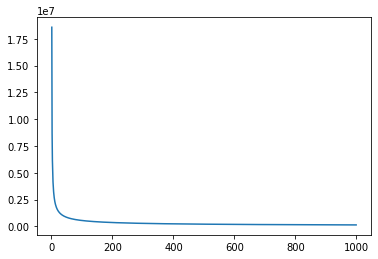

[<matplotlib.lines.Line2D at 0x7f5d70f0b520>]

In [0]:
plt.plot(list(range(1,1000)), counts)

In [0]:
word_counts[word_counts['count']>=300].shape[0]

Out[46]: 282996

### Raw Test Data For Model Analysis

In [0]:
test.show(1)

+--------+-----------+--------------------+--------------------+------------+----------------+--------------------+---------------+--------------------+--------------------+--------------------+
paper_id| doc_type| original_title| paper_title|journal_name|publication_date| topics|abstract_length| abstract| clean_title| clean_abstract|
+--------+-----------+--------------------+--------------------+------------+----------------+--------------------+---------------+--------------------+--------------------+--------------------+
18863665|BookChapter|A Graph Theoretic...|a graph theoretic...| null| 2011-01-01|[complex network,...| 96|The recently deve...|a graph theoretic...|the recently deve...|
+--------+-----------+--------------------+--------------------+------------+----------------+--------------------+---------------+--------------------+--------------------+--------------------+
only showing top 1 row

In [0]:
test.select('paper_id','doc_type','original_title','clean_title','journal_name','abstract_length',
            'abstract','clean_abstract','topics','publication_date') \
.coalesce(1).write.mode("overwrite").parquet("s3://mag-model-data/V2/raw_test_data")

### Loading Fields of Study in Use in OpenAlex

#### Only fields that were seen in 500 papers (in MAG, patents removed) as well as have a wiki ID. This list included some manual searching.

In [0]:
fields_to_use = spark.read.csv("s3://mag-model-data/V2/concepts_with_wiki.csv", header=True) \
.select('normalized_name')

In [0]:
fields_to_use.cache().count()

Out[38]: 65073

In [0]:
fields_to_use.show(10)

+-----------------+
 normalized_name|
+-----------------+
political science|
 philosophy|
 economics|
 business|
 psychology|
 mathematics|
 medicine|
 biology|
 computer science|
 geology|
+-----------------+
only showing top 10 rows

### Vocab

In [0]:
def get_value_counts_for_column(data, col_name):
    if col_name == 'topics':
        counts_df = data.select(F.explode(F.col(col_name)).alias(col_name)).na.drop().groupBy(col_name).count() \
        .orderBy('count', ascending=False) \
        .join(fields_to_use.select(F.col('normalized_name').alias(col_name)), on=col_name)
    else:
        counts_df = data.select('paper_id', col_name).na.drop().groupBy(col_name).count() \
        .orderBy('count', ascending=False)
    return counts_df.toPandas()


def create_vocab(data, save_path, col_name, cutoff=5, unk_token=True, none_token=True, val_count_df=None):
    
    try:
        val_counts = val_count_df.copy()
    except:
        val_counts = get_value_counts_for_column(data, col_name)
    
    val_counts.columns = [f"{col_name}_token", "count"]
    
    final_vocab_df = val_counts[val_counts['count'] >= cutoff].copy()
    
    if unk_token & none_token:
        token_list = ["[UNK]"] + ["[NONE]"] + list(final_vocab_df[f"{col_name}_token"])
    elif unk_token:
        token_list = ["[UNK]"] + list(final_vocab_df[f"{col_name}_token"])
    elif none_token:
        token_list = ["[NONE]"] + list(final_vocab_df[f"{col_name}_token"])
    else:
        token_list = list(final_vocab_df[f"{col_name}_token"])
        
    index_list = list(range(1, len(token_list)+1))
    
    final_vocab = dict(zip(token_list, index_list))
    
    client = boto3.client('s3')
    
    bucket_name = save_path.split("/")[2]
    vocab_key = f"{'/'.join(save_path.split('/')[-3:])}vocab/{col_name}_vocab.pkl"
    _ = client.put_object(Body=pickle.dumps(final_vocab), Bucket=bucket_name, Key=vocab_key)
    
    return final_vocab

In [0]:
def transform_dataset(data, save_path, dataset_type='train', val_count_df=None, doc_type_cutoff=300000, journal_cutoff=50, 
                      topic_cutoff=100, title_cutoff=100):
    if dataset_type=='train':
        print("Getting vocabs")
        doc_vocab = create_vocab(data, save_path, "doc_type", cutoff=doc_type_cutoff, unk_token=True, none_token=True)
        journal_vocab = create_vocab(data, save_path, "journal_name", cutoff=journal_cutoff, unk_token=True, none_token=True)
        target_vocab = create_vocab(data, save_path, "topics", cutoff=topic_cutoff, unk_token=False, none_token=False)
        title_vocab = create_vocab(data, save_path, "paper_title", cutoff=title_cutoff, unk_token=True, none_token=True, val_count_df=val_count_df)
    else:
        print("Loading vocabs")
        client = boto3.client('s3')
        bucket_name = save_path.split("/")[2]
        doc_vocab_key = f"{save_path.split('/')[-2]}/vocab/doc_type_vocab.pkl"
        doc_vocab = pickle.loads(client.get_object(Bucket=bucket_name, Key=doc_vocab_key)['Body'].read())
        journal_vocab_key = f"{save_path.split('/')[-2]}/vocab/journal_name_vocab.pkl"
        journal_vocab = pickle.loads(client.get_object(Bucket=bucket_name, Key=journal_vocab_key)['Body'].read())
        target_vocab_key = f"{save_path.split('/')[-2]}/vocab/topics_vocab.pkl"
        target_vocab = pickle.loads(client.get_object(Bucket=bucket_name, Key=target_vocab_key)['Body'].read())
        title_vocab_key = f"{save_path.split('/')[-2]}/vocab/paper_title_vocab.pkl"
        title_vocab = pickle.loads(client.get_object(Bucket=bucket_name, Key=title_vocab_key)['Body'].read())
    
    print(f"Doc type vocab length: {len(doc_vocab)}")
    print(f"Journal vocab length: {len(journal_vocab)}")
    print(f"Target vocab length: {len(target_vocab)}")
    print(f"Paper title vocab length: {len(title_vocab)}")
    
    def tokenize_target(feature):
        token_feature = []
        for part in feature:
            try:
                token_feature.append(target_vocab[part])
            except:
                pass
        if not token_feature:
            token_feature = [-1]
        return token_feature
    
    def tokenize_feature(feature, feature_name='doc_type'):
        if feature_name=='doc_type':
            vocab = doc_vocab
        else:
            vocab = journal_vocab
        unk_token_id = vocab.get('[UNK]')
        none_token_id = vocab.get('[NONE]')
        if feature:
            token_feature = [vocab.get(feature, unk_token_id)]
        else:
            token_feature = [none_token_id]
        return token_feature
    
    def tokenize_title(feature):
        split_feature = feature.split(" ")
        vocab = title_vocab
        unk_token_id = vocab.get('[UNK]')
        none_token_id = vocab.get('[NONE]')
        if feature:
            token_feature = [vocab.get(x, unk_token_id) for x in split_feature]
        else:
            token_feature = [none_token_id]
        return token_feature

    tokenize_title_udf = F.udf(tokenize_title, ArrayType(IntegerType()))
    tokenize_target_udf = F.udf(tokenize_target, ArrayType(IntegerType()))
    tokenize_feature_udf = F.udf(tokenize_feature, ArrayType(IntegerType()))
    
    print("Tokenizing data")
    final_data = data \
    .withColumn("doc_type_tok", tokenize_feature_udf(F.col('doc_type'), F.lit('doc_type'))) \
    .withColumn("journal_tok", tokenize_feature_udf(F.col('journal_name'), F.lit('journal_name'))) \
    .withColumn("target_tok", tokenize_target_udf(F.col('topics'))) \
    .withColumn("paper_title_tok", tokenize_title_udf(F.col('clean_title'))) \
    .withColumn("abstract_tok", tokenize_title_udf(F.col('clean_abstract')))
    
    print("Saving data")
    if dataset_type == 'train':
        coalesce_num = 100
    elif dataset_type == 'val':
        coalesce_num = 10
    else:
        coalesce_num = 5
    final_data.select('paper_id',
                      'publication_date',
                      'doc_type_tok',
                      'journal_tok',
                      'target_tok',
                      'paper_title_tok',
                      'abstract_tok') \
    .coalesce(coalesce_num).write.mode('overwrite').parquet(f"{save_path}tokenized_data/{dataset_type}")
    

In [0]:
transform_dataset(train, iteration_save_path, 'train', val_count_df=word_counts, doc_type_cutoff=300000, journal_cutoff=50, 
                      topic_cutoff=500, title_cutoff=300)

Getting vocabs
Doc type vocab length: 8
Journal vocab length: 44963
Target vocab length: 65026
Paper title vocab length: 282998
Tokenizing data
Saving data

In [0]:
transform_dataset(val, iteration_save_path, 'val')

Loading vocabs
Doc type vocab length: 8
Journal vocab length: 44963
Target vocab length: 65026
Paper title vocab length: 282998
Tokenizing data
Saving data

In [0]:
transform_dataset(test, iteration_save_path, 'test')

Loading vocabs
Doc type vocab length: 8
Journal vocab length: 44963
Target vocab length: 65026
Paper title vocab length: 282998
Tokenizing data
Saving data

## Get data into TFRecords (Use Local Machine or EC2)